# KNN Evaluation Module

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split


In [3]:
import recmetrics

# Dataset Prep

In [4]:
ratings = pd.read_pickle('../data/processed_data.pkl')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [5]:
#only consider ratings from users who have rated over n recipes
n=1000
users = ratings["user_id"].value_counts()
users = users[users>n].index.tolist()

In [6]:
ratings = ratings.query('user_id in @users')
print(ratings.shape)
ratings.head(3)

(133653, 4)


,rating,name,user_id,recipe_id
2,5,baked potato toppings,14502,34897
34,5,potato crab chowder,11533,32625
78,4,honey glazed baby carrots,31330,82227


## Get features

In [7]:
rated_recipes = ratings["recipe_id"].tolist()

recipes = pd.read_csv('../data/recipes.csv')
recipes = recipes.query('id in @rated_recipes')
recipes.set_index("id", inplace=True, drop=True)

recipes = recipes["tags"].str.strip('][').str.split(", ", expand=True)
recipes.reset_index(inplace=True)

recipes = pd.melt(recipes, id_vars='id', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

recipes.drop_duplicates("id", inplace=True)
recipes.set_index('id', inplace=True)

recipes = pd.get_dummies(recipes.value)
recipes.head()



,'','15-minutes-or-less','30-minutes-or-less','60-minutes-or-less','bacon','celebrity','curries','danish','ham','lactose','oysters','time-to-make','weeknight'
id,,,,,,,,,,,,,
137739,0,0,0,1,0,0,0,0,0,0,0,0,0
31490,0,0,1,0,0,0,0,0,0,0,0,0,0
44061,0,0,0,0,0,0,0,0,0,0,0,0,1
25274,0,1,0,0,0,0,0,0,0,0,0,0,0
67888,0,0,0,0,0,0,0,0,0,0,0,0,1


## Long Tail Plot Example

/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


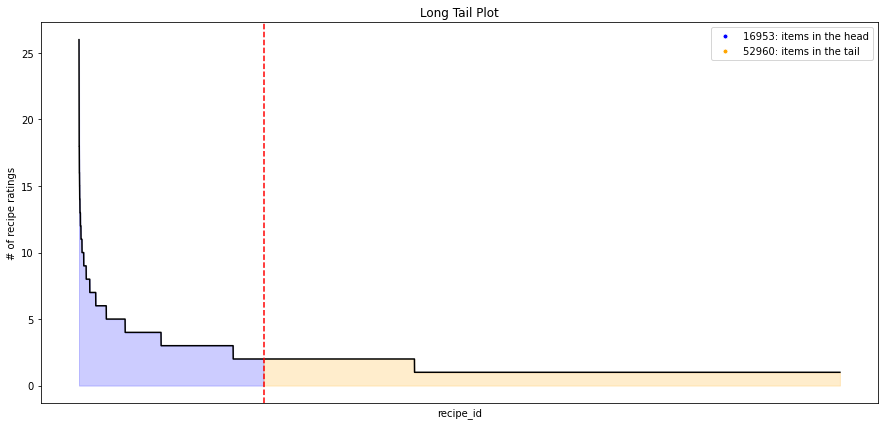

In [8]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="recipe_id", 
             interaction_type="recipe ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

## Format data for Surprise

In [9]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'recipe_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

## Train KNN Recommender

In [10]:
algo = KNNBasic(k=10)
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


## Make predictions on KNN test set

In [11]:
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['user_id', 'recipe_id', 'actual', 'cf_predictions']
test.head()

,user_id,recipe_id,actual,cf_predictions
0,84891,87971,5.0,5.000000
1,44573,97312,5.0,4.604996
2,41651,53596,5.0,4.000000
3,44872,99829,5.0,5.000000
4,3682,135810,4.0,4.810513


## Evaluate model with MSE and RMSE

In [12]:
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.23125081785344168
RMSE:  0.48088545190454834


In [13]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='user_id', columns='recipe_id', values='cf_predictions').fillna(0)

In [14]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [15]:
#get example prediction
get_users_predictions(25281, 10, cf_model)

[118969, 82120, 5240, 47616, 51508, 40964, 5135, 47576, 58867, 64464]

In [16]:
get_users_predictions(31330, 10, cf_model)

[132786, 104556, 127561, 124185, 97502, 108917, 89136, 137501, 70824, 22140]

In [17]:
get_users_predictions(49477, 10, cf_model)

[49092, 117944, 86452, 79977, 138272, 62454, 114593, 104249, 45541, 114508]

In [18]:
test = test.copy().groupby('user_id', as_index=False)['recipe_id'].agg({'actual': (lambda x: list(set(x)))})

In [19]:
test = test.set_index("user_id")

In [20]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
user_id,,
178,"[26632, 45064, 16398, 71701, 55317, 20503, 614...","[102685, 31946, 55407, 44480, 12119, 56339, 45..."
215,"[57348, 9, 12299, 2071, 47142, 41, 92205, 5329...","[111190, 59816, 3701, 63862, 97787, 59767, 465..."
351,"[42496, 35329, 25601, 51203, 3076, 15879, 3892...","[19423, 20387, 37617, 37964, 42138, 13819, 257..."
531,"[6144, 12299, 34831, 77843, 55317, 83998, 1232...","[67985, 4356, 46753, 59198, 15826, 59232, 1581..."
617,"[30722, 9731, 17410, 6661, 8198, 38918, 37384,...","[23957, 9203, 14721, 48352, 48350, 9731, 9048,..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 recipes to every user.

In [21]:
#make recommendations for all members in the test data
popularity_recs = ratings.recipe_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
user_id,,,
178,"[26632, 45064, 16398, 71701, 55317, 20503, 614...","[102685, 31946, 55407, 44480, 12119, 56339, 45...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
215,"[57348, 9, 12299, 2071, 47142, 41, 92205, 5329...","[111190, 59816, 3701, 63862, 97787, 59767, 465...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
351,"[42496, 35329, 25601, 51203, 3076, 15879, 3892...","[19423, 20387, 37617, 37964, 42138, 13819, 257...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
531,"[6144, 12299, 34831, 77843, 55317, 83998, 1232...","[67985, 4356, 46753, 59198, 15826, 59232, 1581...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."
617,"[30722, 9731, 17410, 6661, 8198, 38918, 37384,...","[23957, 9203, 14721, 48352, 48350, 9731, 9048,...","[102617, 30270, 31935, 36145, 19904, 120924, 4..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random recipes to every user.

In [22]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.recipe_id.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
user_id,,,,
178,"[26632, 45064, 16398, 71701, 55317, 20503, 614...","[102685, 31946, 55407, 44480, 12119, 56339, 45...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[66573, 87093, 34105, 85417, 125320, 25179, 26..."
215,"[57348, 9, 12299, 2071, 47142, 41, 92205, 5329...","[111190, 59816, 3701, 63862, 97787, 59767, 465...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[105412, 12622, 137117, 120726, 36568, 11147, ..."
351,"[42496, 35329, 25601, 51203, 3076, 15879, 3892...","[19423, 20387, 37617, 37964, 42138, 13819, 257...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[130539, 20198, 3860, 5844, 133479, 96157, 491..."
531,"[6144, 12299, 34831, 77843, 55317, 83998, 1232...","[67985, 4356, 46753, 59198, 15826, 59232, 1581...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[100547, 43838, 84498, 50762, 139176, 132367, ..."
617,"[30722, 9731, 17410, 6661, 8198, 38918, 37384,...","[23957, 9203, 14721, 48352, 48350, 9731, 9048,...","[102617, 30270, 31935, 36145, 19904, 120924, 4...","[115136, 133121, 22826, 34038, 90933, 79227, 9..."


# Recall

In [23]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [24]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.00025987243467447515,
 0.00030865465585081143,
 0.00035819399610112626,
 0.0004044339952836272,
 0.00045568877855394835,
 0.0004908945078601504,
 0.0005312117521125044,
 0.0005788742725984519,
 0.0006064277241658274,
 0.0006318397955679017]

In [25]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[8.41020616746632e-05,
 0.00015580292888455345,
 0.00015580292888455345,
 0.0001772913903366292,
 0.0001772913903366292,
 0.0001772913903366292,
 0.0001772913903366292,
 0.00018316158851451969,
 0.0001872905781507557,
 0.0001872905781507557]

In [26]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0026992254672276836,
 0.005398450934455367,
 0.00809767640168305,
 0.010796901868910734,
 0.013496127336138418,
 0.0161953528033661,
 0.018894578270593786,
 0.02159380373782147,
 0.02429302920504914,
 0.026992254672276835]

# Mark Plot

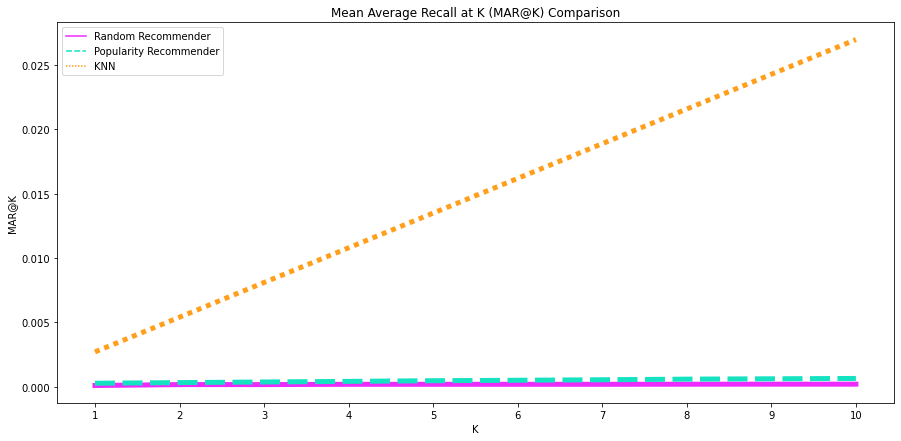

In [27]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'KNN']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Prediction Coverage

In [28]:
catalog = ratings.recipe_id.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)

# Catalog Coverage

In [29]:
# N=100 observed recommendation lists
random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = recmetrics.catalog_coverage(cf_recs, catalog, 100)
print(cf_cat_coverage)

0.86


# Coverage Plot

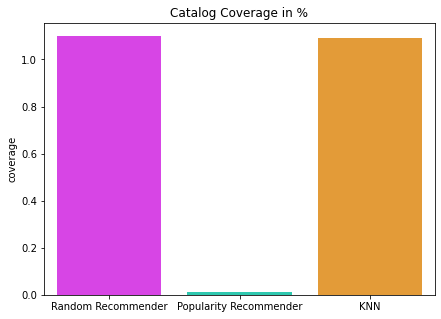

In [30]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'KNN']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Novelty

In [31]:
nov = ratings.recipe_id.value_counts()
pop = dict(nov)

In [32]:
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(users), 10)

In [33]:
print(random_novelty, pop_novelty, cf_novelty)

4.966983600053994 1.7457934751039947 4.565804832785197


# Personalization

In [34]:
example_predictions = [
    
[119108, 137308, 134847, 17434, 93976, 72223, 57514, 25575, 46395, 136101],
[122795, 114541, 134330, 97246, 133418, 94795, 117221, 132804, 82001, 93682],
[90679, 126624, 64784, 135852, 116733, 122320, 77854, 135817, 66984, 116588]
]

In [35]:
recmetrics.personalization(predicted=example_predictions)

1.0

# Intra-list Similarity

In [36]:
example_predictions = [
[137308, 134847, 17434, 93976, 57514, 25575,  136101],
[134330, 94795, 117221, 132804, 82001],
[126624, 64784, 77854, 66984, 116588]
]

In [37]:
feature_df = recipes[["'60-minutes-or-less'","'30-minutes-or-less'","'15-minutes-or-less'"]]

In [38]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.19523809523809524

# Classification Probability Plot

In [39]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.722703,1.0
1,0.754742,1.0
2,0.686129,1.0
3,0.620876,1.0
4,0.904891,1.0


/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/scott_wang/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


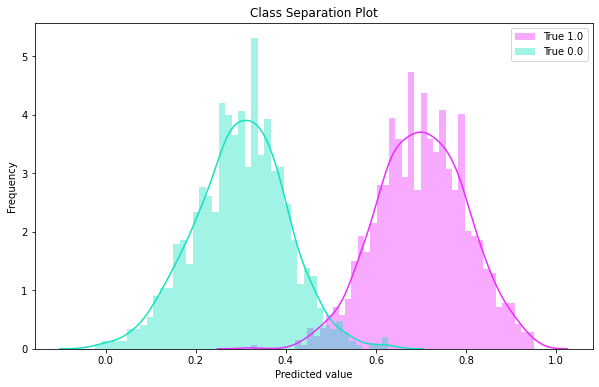

In [40]:
recmetrics.class_separation_plot(pred_df, n_bins=45, title="Class Separation Plot")

# ROC Plot

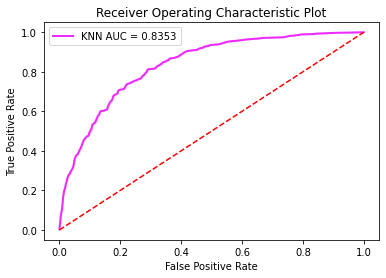

In [44]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="KNN",  figsize=(10, 5))

# Precision Recall Curve

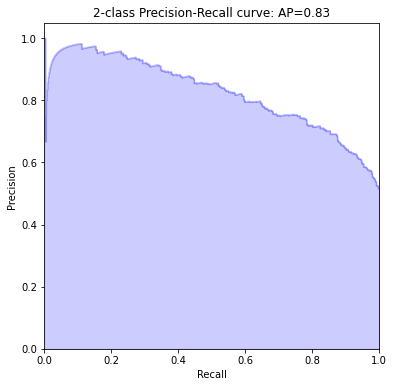

In [42]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)